## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

## Extracting data

In [2]:
mammo_df = pd.read_csv('mammographic_masses.data.txt',
                       names=['bi-rads','age','shape','margin','density','severity'],na_values='?')
print(mammo_df.shape)

(961, 6)


In [3]:
mammo_df.head()

,bi-rads,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


The input data has 6 columns - severity is the target variable that we are trying to predict. The below are description of those attributes.

BI-RADS assessment: 1 to 5 (ordinal) 

Age: patient's age in years (integer)

Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)

Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)

Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)

Severity: benign=0 or malignant=1 (binominal)

In [4]:
mammo_df.describe()

,bi-rads,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


Clearly there are null values in our dataset, let us identify and drop the null values. There maybe less scope to replace the null values for this dataset.

### Remove null values

In [5]:
mammo_df.isnull().any()

bi-rads      True
age          True
shape        True
margin       True
density      True
severity    False
dtype: bool

In [6]:
mammo_df = mammo_df.dropna(how='any')
mammo_df.drop(['bi-rads'],axis=1,inplace=True)
mammo_df.reset_index(inplace=True,drop=True)
print(mammo_df.shape)

(830, 5)


In [7]:
mammo_df.describe()

,age,shape,margin,density,severity
count,830.000000,830.000000,830.000000,830.000000,830.000000
mean,55.781928,2.781928,2.813253,2.915663,0.485542
std,14.671782,1.242361,1.567175,0.350936,0.500092
min,18.000000,1.000000,1.000000,1.000000,0.000000
25%,46.000000,2.000000,1.000000,3.000000,0.000000
50%,57.000000,3.000000,3.000000,3.000000,0.000000
75%,66.000000,4.000000,4.000000,3.000000,1.000000
max,96.000000,4.000000,5.000000,4.000000,1.000000


The dataset contains respondents with age in the range between 18 and 96. We removed the bi-rads column which is not a predictive attribute so we dropped it.The shape, margin and density indicate characteristics of the mammographic masses. Severity is our target attribute which has two values 0 and 1, which correspond to benign and malignant mass respectively.

In [8]:
mammo_df.tail()

,age,shape,margin,density,severity
825,47.0,2.0,1.0,3.0,0
826,56.0,4.0,5.0,3.0,1
827,64.0,4.0,5.0,3.0,0
828,66.0,4.0,5.0,3.0,1
829,62.0,3.0,3.0,3.0,0


## Exploratory data analysis

Text(0.5, 1.0, 'Age distribution')

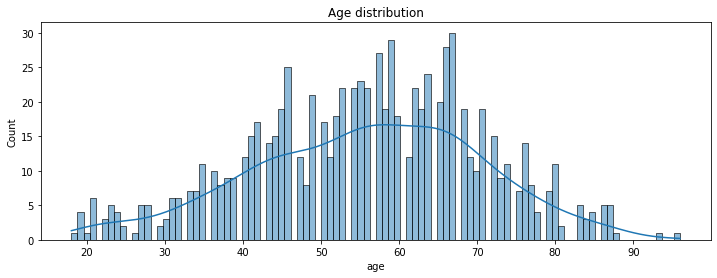

In [9]:
mammo_eda = mammo_df.copy()
mammo_eda.replace({'shape': {1: 'round', 2: 'oval', 3: 'lobular', 4: 'irregular'},
                   'margin': {1: 'circumscribed', 2: 'microlobulated', 3: 'obscured', 4: 'ill-defined', 5: 'spiculated'},
                   'density': {1: 'high', 2: 'iso', 3: 'low', 4: 'fat-containing'},
                   'severity': {1: 'malignant', 0: 'benign'}}, inplace=True)
plt.figure(figsize=(12,4))
fig = sns.histplot(data=mammo_eda,x='age',bins=100,kde=True)
fig.set_title('Age distribution')

We replaced the numerical values in our dataset - shape, margin and density with the corresponding attribute so that we can explore the dataset visually. The age distribution shows the variable is almost normally distributed with mean around 60.

Text(0.5, 1.0, 'Density value counts')

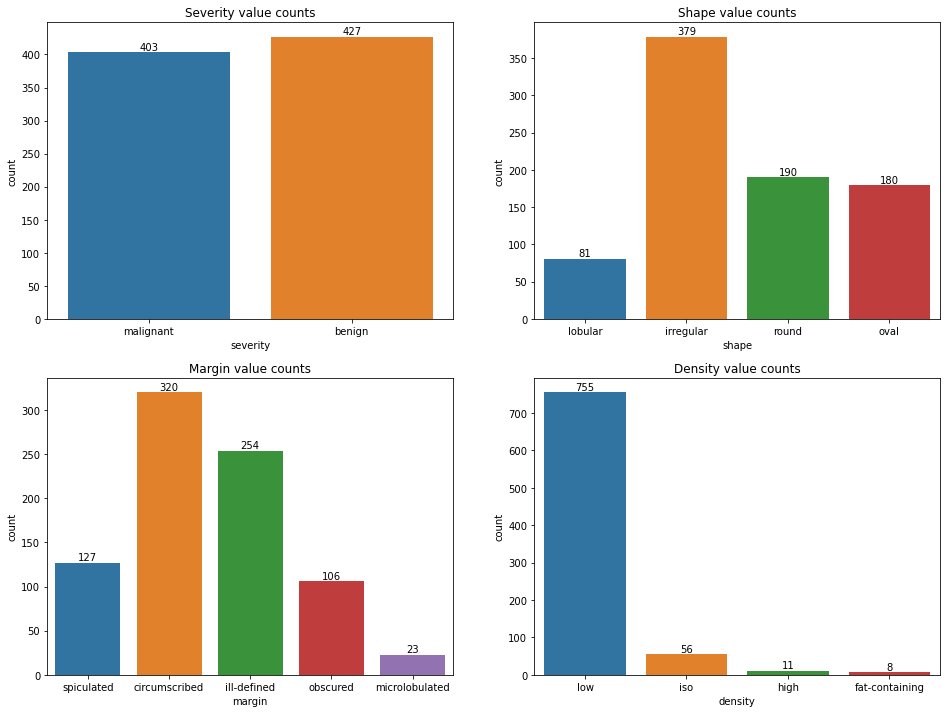

In [10]:
fig, ax = plt.subplots(2,2,figsize=(16,12))

sev = sns.countplot(ax=ax[0,0],x=mammo_eda['severity'])
for i in sev.containers:
    sev.bar_label(i,)
ax[0,0].set_title('Severity value counts')
shp = sns.countplot(ax=ax[0,1],x=mammo_eda['shape'])
for i in shp.containers:
    shp.bar_label(i,)
ax[0,1].set_title('Shape value counts')
mar = sns.countplot(ax=ax[1,0],x=mammo_eda['margin'])
for i in mar.containers:
    mar.bar_label(i,)
ax[1,0].set_title('Margin value counts')
den = sns.countplot(ax=ax[1,1],x=mammo_eda['density'])
for i in den.containers:
    den.bar_label(i,)
ax[1,1].set_title('Density value counts')

We can analyze the count plots for each categorical column from our dataset above:
1. Severity is almost distributed equally within our dataset - there are 403 malignant observations and 427 benign observations.
2. The shape of almost half of the observations are 'irregular'.
3. The margin attribute is also variously distributed.
4. The density is an ordinal attribute with most of the observations corresponding to low density.

Text(0.5, 1.0, 'Severity per margin')

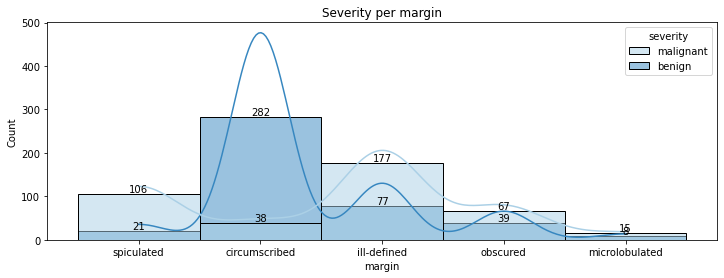

In [11]:
plt.figure(figsize=(12,4))
hist_mar = sns.histplot(x='margin',hue='severity',data=mammo_eda, kde=True,palette='Blues')
for i in hist_mar.containers:
    hist_mar.bar_label(i,)
hist_mar.set_title('Severity per margin')

We can observe from the above histogram that circumscribed margins usually are benign while other margin classes may have more chance of being malignant.

Text(0.5, 1.0, 'Severity per shape')

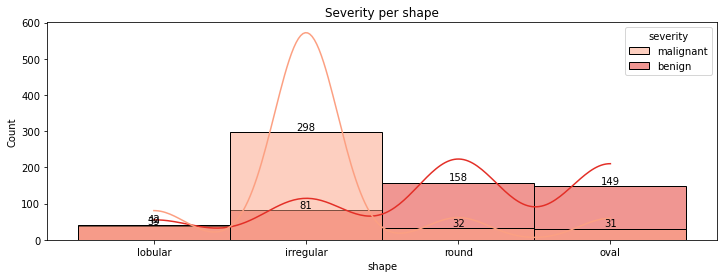

In [12]:
plt.figure(figsize=(12,4))
hist_shape = sns.histplot(x='shape',hue='severity',data=mammo_eda, kde=True,palette='Reds')
for i in hist_shape.containers:
    hist_shape.bar_label(i,)
hist_shape.set_title('Severity per shape')

For observations with irregular shapes, there is more chance of the mass being malignant compared to other shapes.

Text(0.5, 1.0, 'Severity per density')

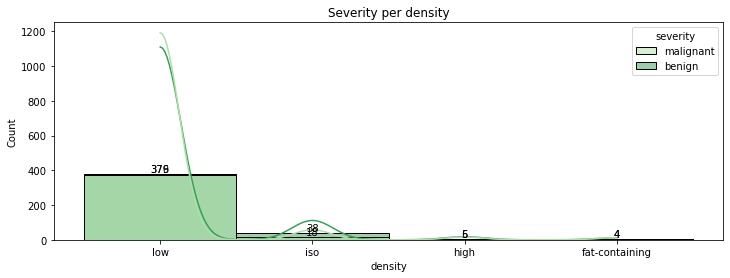

In [13]:
plt.figure(figsize=(12,4))
hist_den = sns.histplot(x='density',hue='severity',data=mammo_eda, kde=True,palette='Greens')
for i in hist_den.containers:
    hist_den.bar_label(i,)
hist_den.set_title('Severity per density')

Since the distribution of density is very biased with lots of low density observations, there is little that can be concluded from above graph.

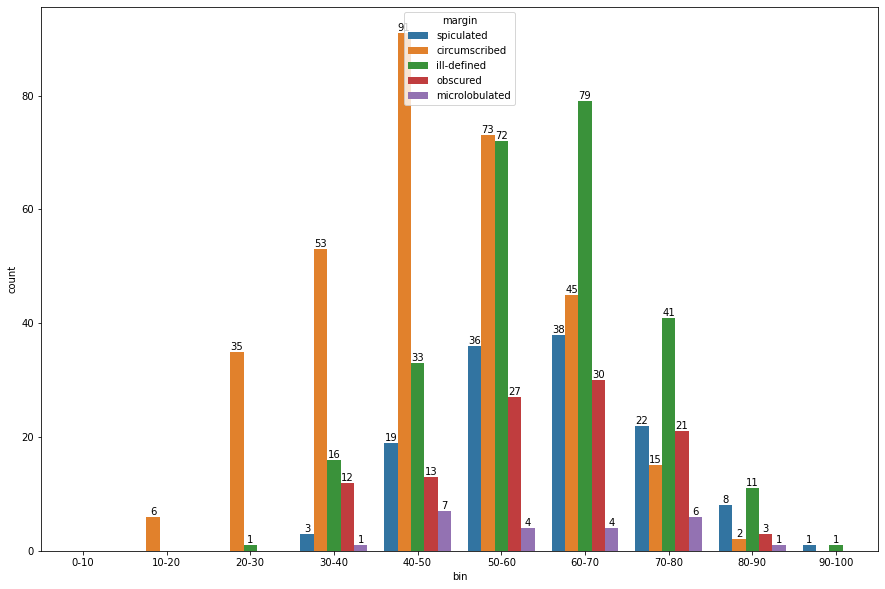

In [14]:
mammo_eda['bin'] = pd.cut(mammo_eda['age'], bins=range(0,101,10), labels=[f'{l}-{l+10}' for l in range(0,91,10)])
plt.figure(figsize=(15,10))
hued1 = sns.countplot(x='bin', hue='margin', data=mammo_eda)
for i in hued1.containers:
    hued1.bar_label(i,)

The above countplot shows the distribution of margin attribute among different age groups. Clearly circumscribed margins are more frequent with younger age groups while older aged observations have ill-defined margins more frquently.

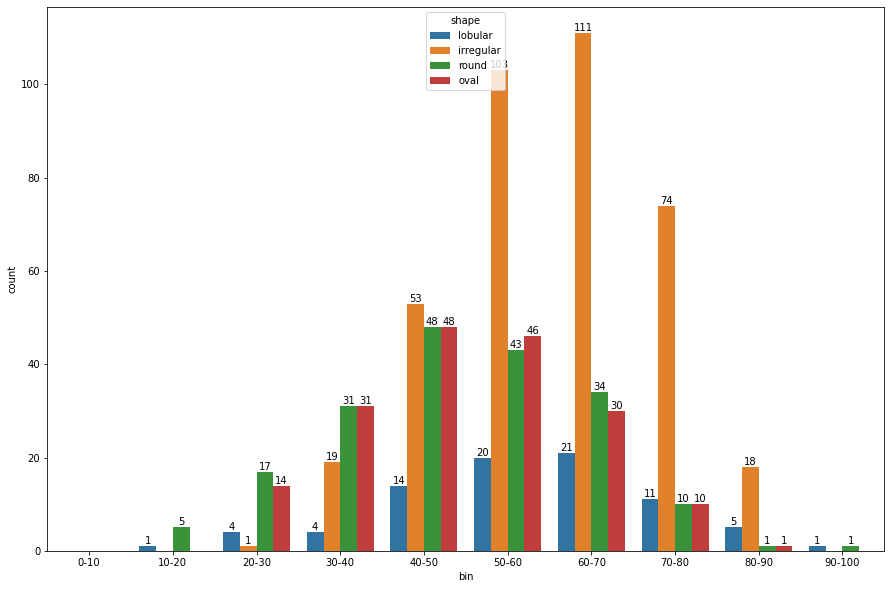

In [15]:
plt.figure(figsize=(15,10))
hued2 = sns.countplot(x='bin', hue='shape', data=mammo_eda)
for i in hued2.containers:
    hued2.bar_label(i,)

Above plot to observe the distribution of shape attribute shows that irregular shape are most frquently associated with an increase in age.

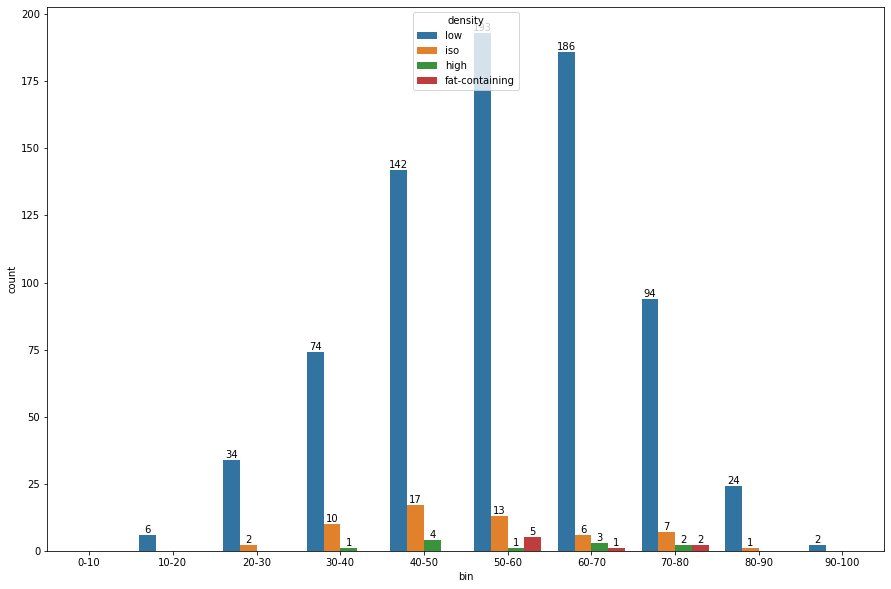

In [16]:
plt.figure(figsize=(15,10))
hued3 = sns.countplot(x='bin', hue='density', data=mammo_eda)
for i in hued3.containers:
    hued3.bar_label(i,)

The density-age distribution is again pretty inconclusive since low density observations are overly dominant in our dataset.

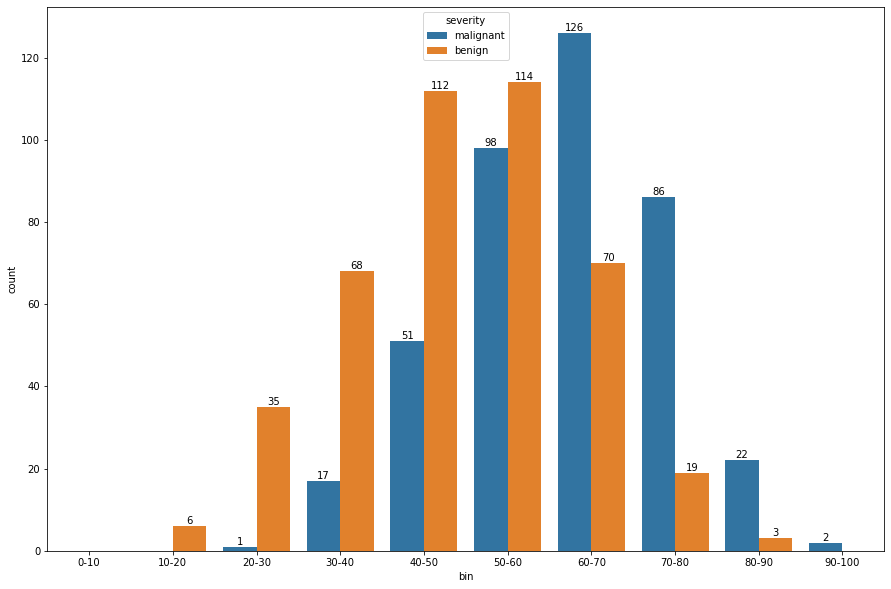

In [17]:
plt.figure(figsize=(15,10))
hued4 = sns.countplot(x='bin', hue='severity', data=mammo_eda)
for i in hued4.containers:
    hued4.bar_label(i,)    

The above plot shows that the observational masses are increasingly found to be malignant for very aged observations, i.e. above 60.

Text(0.5, 1.0, 'Shape vs age')

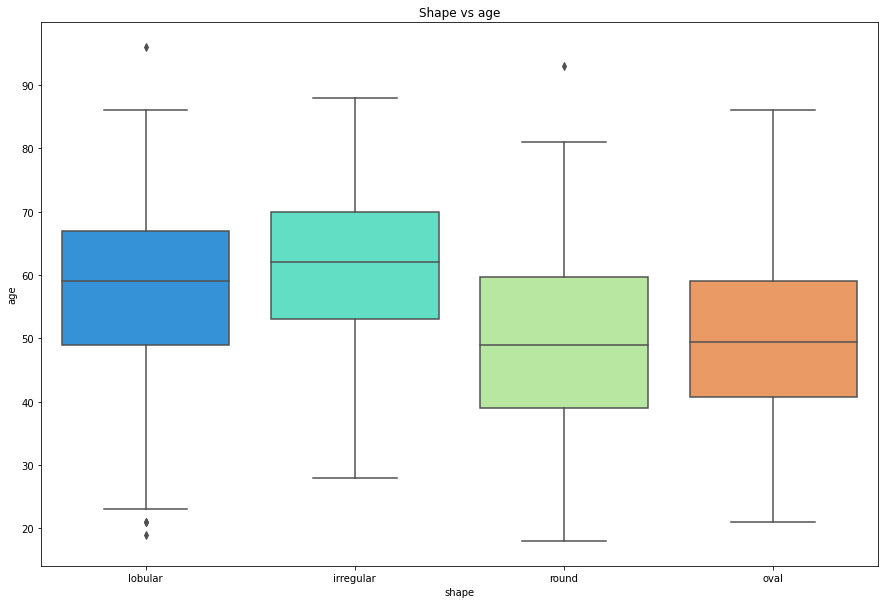

In [18]:
plt.figure(figsize=(15,10))
shape_box=sns.boxplot(x='shape',y='age',data=mammo_eda, palette='rainbow')
shape_box.set_title('Shape vs age')

Previously we plotted the distribution of attributes across age groups by binning the age value. Now, we have plotted the distribution of different attributes by age using boxplots above. This will be helpful to illustrate further how these attributes vary by age. For example, the above plot suggests that round and oval shapes are more common in younger age groups.

Text(0.5, 1.0, 'Density vs age')

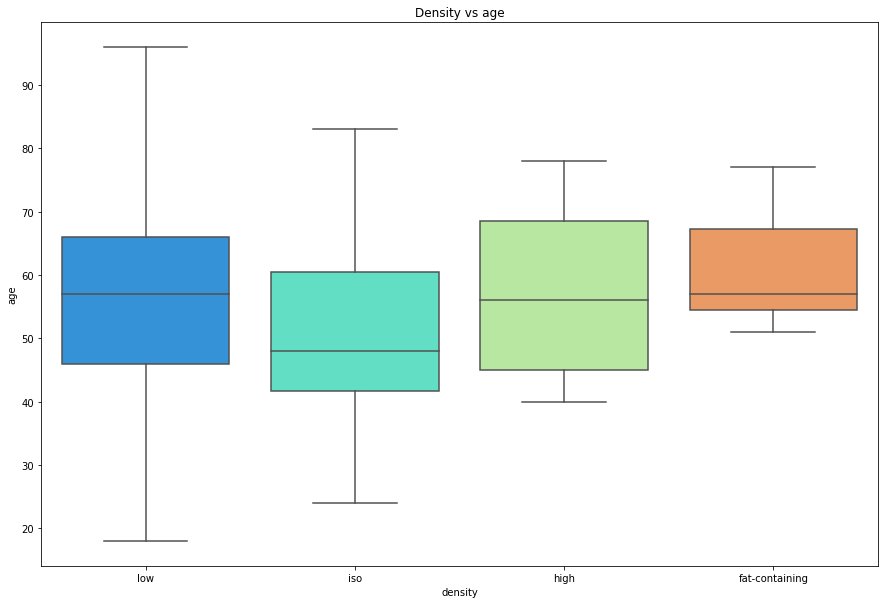

In [19]:
plt.figure(figsize=(15,10))
den_box=sns.boxplot(x='density',y='age',data=mammo_eda, palette='rainbow')
den_box.set_title('Density vs age')

Text(0.5, 1.0, 'Margin vs age')

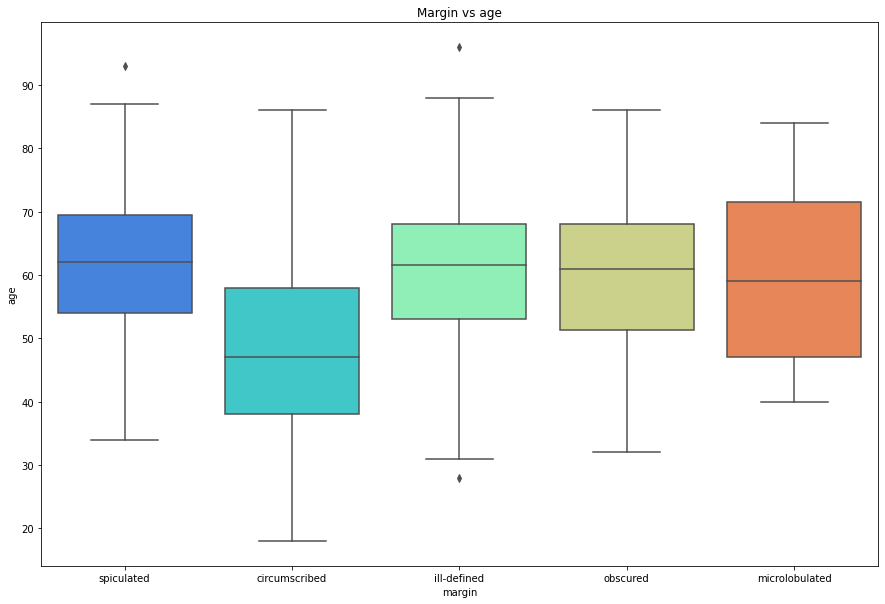

In [20]:
plt.figure(figsize=(15,10))
mrg_box=sns.boxplot(x='margin',y='age',data=mammo_eda, palette='rainbow')
mrg_box.set_title('Margin vs age')

Again, we see that the circumscribed observations are mostly associated with less aged observations. There is not significant variation between other margins.

Text(0.5, 1.0, 'Severity vs age')

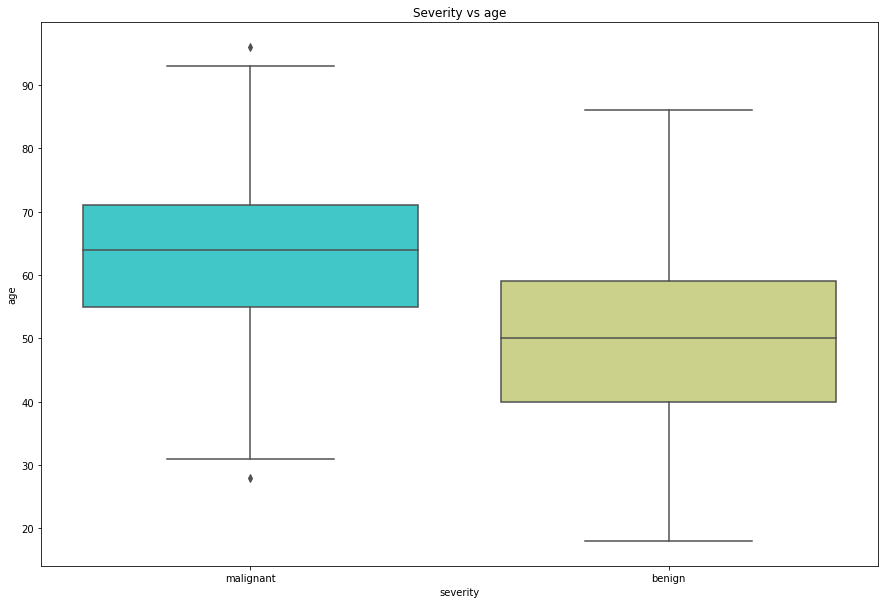

In [21]:
plt.figure(figsize=(15,10))
sev_box=sns.boxplot(x='severity',y='age',data=mammo_eda, palette='rainbow')
sev_box.set_title('Severity vs age')

The benign observations mostly correspond to younger aged observations with mean around 50. Malignant observations have a mean of around 65.

## Model training

### Train test split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(mammo_df.drop(['severity'],axis=1),
                                                    mammo_df['severity'],test_size=0.25, random_state=42)

We have split the data into train and test sets with 75% allocation to training.

In [23]:
X_train.head()

,age,shape,margin,density
90,41.0,1.0,1.0,3.0
777,57.0,3.0,3.0,3.0
181,73.0,4.0,4.0,3.0
764,41.0,1.0,1.0,3.0
380,40.0,4.0,3.0,3.0


In [24]:
y_train[:5]

90     0
777    1
181    1
764    0
380    1
Name: severity, dtype: int64

In [25]:
print("Training samples percent: ",len(X_train.index)/len(mammo_df.index)*100)
print("Test samples percent: ",len(X_test.index)/len(mammo_df.index)*100)

Training samples percent:  74.93975903614458
Test samples percent:  25.060240963855424


In [26]:
print("False values in original set: ", len(mammo_df[mammo_df['severity']==0].index)/len(mammo_df.index))
print("True values in original set: ", len(mammo_df[mammo_df['severity']==1].index)/len(mammo_df.index))
print("False values in train set: ", len(y_train[y_train==0].index)/len(y_train.index))
print("True values in train set: ", len(y_train[y_train==1].index)/len(y_train.index))
print("False values in test set: ", len(y_test[y_test==0].index)/len(y_test.index))
print("True values in test set: ", len(y_test[y_test==1].index)/len(y_test.index))

False values in original set:  0.5144578313253012
True values in original set:  0.4855421686746988
False values in train set:  0.5160771704180064
True values in train set:  0.48392282958199356
False values in test set:  0.5096153846153846
True values in test set:  0.49038461538461536


The benign and malignant observations are almost equally spread out in trianing and test sets as it is in the original dataset.

## Model evaluation

In [27]:
bestfeatures = SelectKBest(score_func=f_classif, k=4)

fit = bestfeatures.fit(mammo_df.drop('severity',axis=1),mammo_df['severity'])
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(mammo_df.drop('severity',axis=1).columns)
 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)

featureScores.columns = ['Specs','Score']
print(featureScores.sort_values(by='Score',ascending=False))

     Specs       Score
2   margin  407.908580
1    shape  387.782271
0      age  216.427503
3  density    3.920754


We have used the SelectKBest algorithm to identify that density attribute adds very little value to our prediction mechanism. This is probably because most of the observations correspond to low density. At this stage, we can understand that collecting additional data with other density values may help our algorithms to predict better.

Let us evaluate the classification model using different machine learning algorithms. Below, we have defined custom functions to determine the classification metrics and plot a confusion matrix.

In [28]:
def cm_func():
    cm = confusion_matrix(y_test,y_pred)
    df_cm = pd.DataFrame(cm,index= [i for i in ['benign','malignant']], 
                         columns = [i for i in ['Pred benign','Pred malignant']])
    plt.figure(figsize=(7,5))
    sns.heatmap(df_cm,annot=True)
    return cm
def perf(alg):
    cm=cm_func()
    a = round((cm[0,0] + cm[1,1]) / (cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1]),3)
    p = round(cm[1,1] / (cm[1,1] + cm[0,1]),3)
    r = round(cm[1,1] / (cm[1,1] + cm[1,0]),3)
    f = round((2 * p * r) / (p + r),3)
    perf_comp[alg] = [a,p,r,f]
    print("accuracy : ",a)
    print("precision: ",p)
    print("recall   : ",r)
    print("F1 score : ",f)
    print("\nConfusion matrix - ",alg)

accuracy :  0.827
precision:  0.789
recall   :  0.882
F1 score :  0.833

Confusion matrix -  Logistic Regression


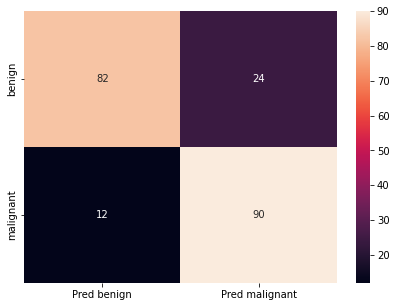

In [29]:
clf = LogisticRegression(solver='liblinear',random_state=42,C=10)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
perf_comp = pd.DataFrame(index=['accuracy','precision','recall','F1 score'])
perf('Logistic Regression')

The model provides around 83% accuracy with 24 false positives and 12 false negatives. Generally in healthcare domains, we would focus on reducing the false negatives. The reason behind it being that predictions of benign observations may left untreated further and may cause harmful consequences.

### K Nearest Neighbors

Let us try out the K Nearest Neighbors classification. The below hyperparameters provide better classification.

accuracy :  0.832
precision:  0.786
recall   :  0.902
F1 score :  0.84

Confusion matrix -  K Nearest Neighbors


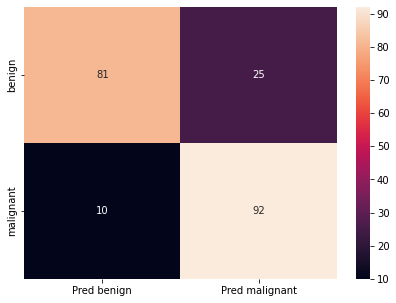

In [30]:
knn = KNeighborsClassifier(n_neighbors=16,leaf_size=10)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
perf('K Nearest Neighbors')

KNN has performed similar to Logistic Regression. Let us check if we can get consistent results with this algorithm by using the K-Fold cross validation.

In [31]:
kf = KFold(n_splits=6, random_state=42, shuffle=True)
knn_kf = KNeighborsClassifier(n_neighbors=16,leaf_size=10)

scores=[]
for i in range(6):
    result = next(kf.split(mammo_df), None)
    X_train_kf = mammo_df.drop(columns='severity').iloc[result[0]]
    X_test_kf = mammo_df.drop(columns='severity').iloc[result[1]]
    y_train_kf = mammo_df['severity'].iloc[result[0]]
    y_test_kf = mammo_df['severity'].iloc[result[1]]
    knn_kf_scaler = MinMaxScaler()
    X_train_scaled_kf = knn_kf_scaler.fit_transform(X_train_kf)
    X_test_scaled_kf = knn_kf_scaler.fit_transform(X_test_kf)
    knn_kf_model = knn_kf.fit(X_train_scaled_kf,y_train_kf)
    y_pred_kf = knn_kf.predict(X_test_scaled_kf)
    scores.append(knn_kf_model.score(X_test_scaled_kf,y_test_kf))
print('Scores from each Iteration: ', scores)
print('Average K-Fold Score :' , np.mean(scores))

Scores from each Iteration:  [0.8129496402877698, 0.8129496402877698, 0.8129496402877698, 0.8129496402877698, 0.8129496402877698, 0.8129496402877698]
Average K-Fold Score : 0.81294964028777


K Nearest Neighbors provide slightly better results compared to Logistic Regression technique. We may still improve the KNN algorithm by scaling the input features - this is because the age value ranges from 18 to 96 however the other attributes have very small range. Since KNN works based on a distance metric, the age attribute may have huge dominance owing to its range. Let us perform the below preprocessing to improve the prediction performance.
1. Standardize the input data so that age attribute is brought to range 0-1.
2. One-hot encoding of shape and margin categorical attributes.

In [32]:
mammo_ohe = mammo_df.copy()
mammo_ohe.replace({'shape': {1: 'round', 2: 'oval', 3: 'lobular', 4: 'irregular'},
    'margin': {1: 'circumscribed', 2: 'microlobulated', 3: 'obscured', 4: 'ill-defined', 5: 'spiculated'}},
                  inplace=True)
enc = OneHotEncoder(handle_unknown='ignore')
mammo_ohetf = pd.DataFrame(enc.fit_transform(mammo_ohe[['shape','margin']]).toarray(),columns=enc.get_feature_names_out())
mammo_ohe = mammo_ohe.join(mammo_ohetf)
mammo_ohe.drop(['shape','margin','shape_irregular','margin_circumscribed'],axis=1,inplace=True)
mammo_ohe.head(2)

,age,density,severity,shape_lobular,shape_oval,shape_round,margin_ill-defined,margin_microlobulated,margin_obscured,margin_spiculated
0,67.0,3.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,58.0,3.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [33]:
X_train_ohe, X_test_ohe, y_train, y_test = train_test_split(mammo_ohe.drop(['severity'],axis=1),
                                                    mammo_ohe['severity'],test_size=0.25, random_state=42)

In [34]:
scaler = MinMaxScaler()
X_train_scl = X_train_ohe.copy()
X_test_scl = X_test_ohe.copy()
X_train_scl[['age']] = scaler.fit_transform(X_train_scl[['age']])
X_test_scl[['age']] = scaler.fit_transform(X_test_scl[['age']])
X_train_scl.head(2)

,age,density,shape_lobular,shape_oval,shape_round,margin_ill-defined,margin_microlobulated,margin_obscured,margin_spiculated
90,0.285714,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
777,0.493506,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


accuracy :  0.832
precision:  0.807
recall   :  0.863
F1 score :  0.834

Confusion matrix -  K Nearest Neighbors (preprocessed)


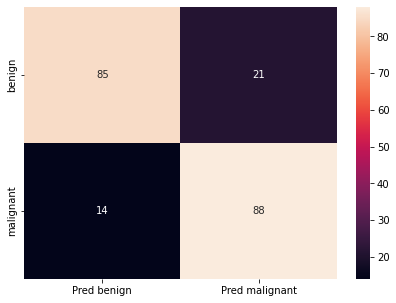

In [35]:
knn = KNeighborsClassifier(n_neighbors=16,leaf_size=10)
knn.fit(X_train_scl, y_train)
y_pred = knn.predict(X_test_scl)
perf('K Nearest Neighbors (preprocessed)')

Scaling has improved the precision but recall has waned a little. There may still be more scope of improved performance using other methods. 

### Gaussian Naive Bayes

accuracy :  0.827
precision:  0.784
recall   :  0.892
F1 score :  0.835

Confusion matrix -  Gaussian Naive Bayes


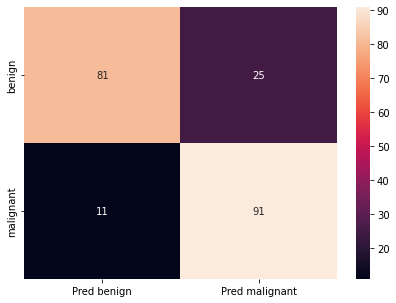

In [36]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
perf('Gaussian Naive Bayes')

Gaussian Naive Bayes provide almost similar results compared to Logistic Regression algorithm.

### Support Vector Classifier

In [37]:
svc = SVC(gamma='scale')
svc.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 0.76
Accuracy on test set: 0.76


The accuracy provided by Support Vector Classifier is less. The Support Vector classifier essentially splits the mathematical space by creating a decision boundary between classes. The decision boundary maximizes the distance to the nearest data points from different classes. Hence, the distance between data points affects the decision boundary SVM chooses. In our dataset, the age is an integer ranging between 18 and 96 but the other predictors are very small in range. So, the model can predict better only when all the predictors are scaled to a similar range.

In [39]:
svc = SVC(gamma='scale')
svc.fit(X_train_scl, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train_scl, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test_scl, y_test)))

Accuracy on training set: 0.80
Accuracy on test set: 0.83


We can see the performance has improved now, let us input the scaled data again to SVC algorithm. Let us decrease the strength of regularization to see if it improves the prediction.

accuracy :  0.827
precision:  0.795
recall   :  0.873
F1 score :  0.832

Confusion matrix -  Gaussian NB (preprocessed)


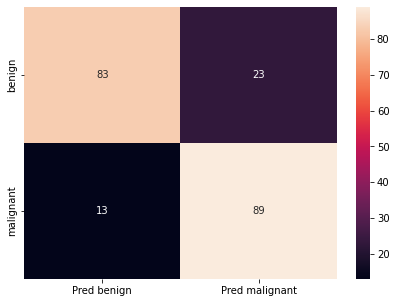

In [40]:
svc = SVC(C=1000,gamma='scale')
svc.fit(X_train_scl, y_train)
y_pred = svc.predict(X_test_scl)
perf('Gaussian NB (preprocessed)')

The performance of Support Vector Classifier is comparable to other earlier models. Let us try the Decision Tree classifier algorithm.

### Decision Tree Classifier

accuracy :  0.832
precision:  0.777
recall   :  0.922
F1 score :  0.843

Confusion matrix -  Decision Tree Classifier


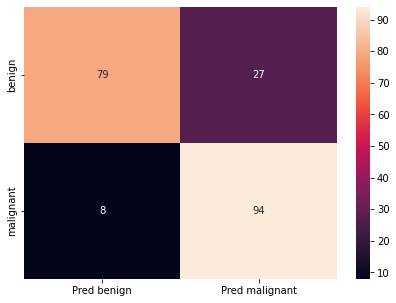

In [41]:
dtree = DecisionTreeClassifier(criterion='gini',random_state=10,max_depth=5,min_samples_leaf=7)
dtree.fit(X_train,y_train)
y_pred = dtree.predict(X_test)
perf('Decision Tree Classifier')

The precision provided by Decision Tree Classifier is very low.

accuracy :  0.808
precision:  0.777
recall   :  0.853
F1 score :  0.813

Confusion matrix -  Decision Tree Classifier (preprocessed)


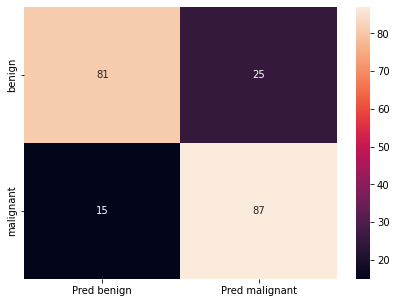

In [42]:
dtree = DecisionTreeClassifier(criterion='gini',random_state=42,max_depth=5,min_samples_leaf=7)
dtree.fit(X_train_scl,y_train)
y_pred = dtree.predict(X_test_scl)
perf('Decision Tree Classifier (preprocessed)')

The sclaing and one-hot encoding has probably decreased the performance of the classifier. Let us proceed with other methods.

## Neural network classifier (using Keras)

In [43]:
model = Sequential()
model.add(Dense(500, activation='relu', input_shape=(4,)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               2500      
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 501       
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
history = model.fit(X_train, y_train, epochs=200, verbose=0, validation_data=(X_test, y_test))

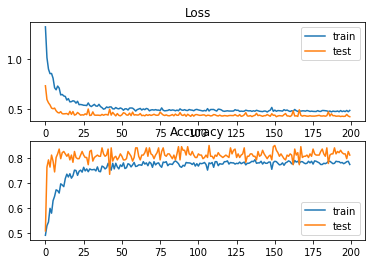

In [47]:
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [48]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
y_pred_proba = model.predict(X_test)

Test loss: 0.4194892346858978
Test accuracy: 0.8125


accuracy :  0.812
precision:  0.748
recall   :  0.931
F1 score :  0.83

Confusion matrix -  Neural network


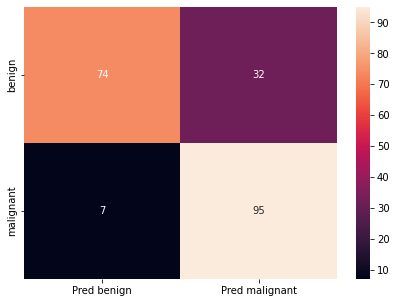

In [49]:
y_pred=(y_pred_proba>0.5).astype("int32")
perf('Neural network')

Neural networks have been known to provide better performance with one-hot encoded inputs. We will create another model to compare the predictions.

In [50]:
model2 = Sequential()
model2.add(Dense(500, activation='relu', input_shape=(9,)))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

In [51]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 500)               5000      
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 501       
                                                                 
Total params: 5,501
Trainable params: 5,501
Non-trainable params: 0
_________________________________________________________________


In [52]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
history1 = model2.fit(X_train_scl, y_train, epochs=200, verbose=0, validation_data=(X_test_scl, y_test))

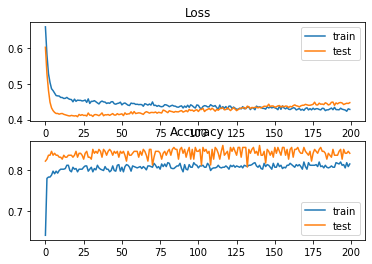

In [54]:
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history1.history['loss'], label='train')
pyplot.plot(history1.history['val_loss'], label='test')
pyplot.legend()
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history1.history['accuracy'], label='train')
pyplot.plot(history1.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [55]:
score = model2.evaluate(X_test_scl, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
y_pred_proba_ohe = model2.predict(X_test_scl)

Test loss: 0.4472821354866028
Test accuracy: 0.8413461446762085


accuracy :  0.841
precision:  0.8
recall   :  0.902
F1 score :  0.848

Confusion matrix -  Neural network (preprocessed)


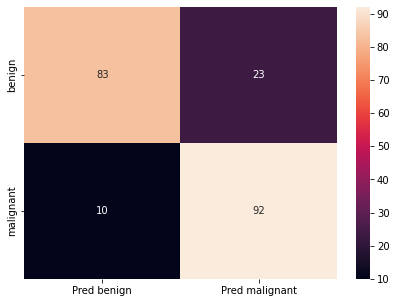

In [56]:
y_pred=(y_pred_proba_ohe>0.5).astype("int32")
perf('Neural network (preprocessed)')

We can observe the performance has improved a slight bit on using the preprocessed inputs.

In [57]:
perf_comp

,Logistic Regression,K Nearest Neighbors,K Nearest Neighbors (preprocessed),Gaussian Naive Bayes,Gaussian NB (preprocessed),Decision Tree Classifier,Decision Tree Classifier (preprocessed),Neural network,Neural network (preprocessed)
accuracy,0.827,0.832,0.832,0.827,0.827,0.832,0.808,0.812,0.841
precision,0.789,0.786,0.807,0.784,0.795,0.777,0.777,0.748,0.800
recall,0.882,0.902,0.863,0.892,0.873,0.922,0.853,0.931,0.902
F1 score,0.833,0.840,0.834,0.835,0.832,0.843,0.813,0.830,0.848


It looks like the neural network feeded with preprocessed inputs have actually provided better results of all our models. We are curious to understand what kind of data have been wrongly predicted by our model. This can help fine tune to our model such as collection of additional input data of specific type or other techniques.

In [58]:
test_set = X_test.copy()
test_set['actual'] = y_test
test_set['pred'] = y_pred
test_set['pred_crct'] = test_set['actual']==test_set['pred']
test_set.head()

,age,shape,margin,density,actual,pred,pred_crct
608,59.0,1.0,1.0,3.0,0,0,True
457,44.0,2.0,1.0,3.0,0,0,True
290,55.0,4.0,5.0,3.0,0,1,False
558,24.0,2.0,1.0,3.0,0,0,True
168,46.0,1.0,1.0,3.0,0,0,True


In [59]:
test_set.groupby(by='pred_crct').mean()

,age,shape,margin,density,actual,pred
pred_crct,,,,,,
False,54.515152,3.030303,3.363636,3.000000,0.303030,0.696970
True,55.942857,2.725714,2.805714,2.914286,0.525714,0.525714


Our model has predicted more of the observations as malignant (positive) cases but it looks to have misidentified data with higher margin values such as ill-defined and spiculated masses.